# Weird issue with precision when using weighted mean

I was not yet able to reproduce this with a simpler example...

In [15]:
import gcsfs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scale_aware_air_sea.cm26_utils import load_and_combine_cm26

fs = gcsfs.GCSFileSystem()

In [9]:
ds_merged  = load_and_combine_cm26(fs, inline_array=True)

# reverse the fix I built into the loading
ds_merged.coords['area_t'] = ds_merged.coords['area_t'].astype(np.float32)

Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


In [10]:
# TODO import this from module
from typing import Mapping, Any
def weighted_coarsen(ds:xr.Dataset, dim: Mapping[Any, int],  weight_coord:str, **kwargs) -> xr.Dataset:
    
    # Check that the weights have no missing values
    weights = ds[weight_coord]
    if np.isnan(weights).sum()>0:
        raise ValueError(f'Found missing values in weights coordinate ({weight_coord}). Please fill with zeros before.')
        
    # Make sure that the weights are matching the missing values in the input data 
    # (otherwise creation of aggregated area will be ambigous and depend on each variable)
    # the important thing to check is if a) all variables have the same mask and
    variable_missing = np.isnan(ds.isel(time=0).to_array())
    variable_mask = variable_missing.any('variable').load() # loading because we need it multiple times
    variable_test = variable_missing.all('variable')
    if not variable_mask.equals(variable_test):
        raise ValueError('Found variables with non-matching missing values. ',
                         'Make sure that the missing values in **all** variables are in the same position.')
    
    # and b) if the weights have nonzero values that do not match the variables (this would lead to additional area being counted below) 
    weights_test = weights<=0
    if not np.allclose(variable_mask,weights_test):
        raise ValueError(
            'Missing values in variables are not matching locations of <=0 values in weights array. ',
            'Please change your weights to only have missing values or zeros where variables have missing values.'
        )
    
    # start the actual calculation
    ds_coarse = ds.coarsen(**dim, **kwargs)
    # construct internal/external dims
    construct_kwargs = {di:(di+'_external', di+'_internal') for di in dim}
    ds_construct = ds_coarse.construct(**construct_kwargs)
    
    # apply weighted mean over internal dimensions
    weights_coarse = ds_construct[weight_coord]
    aggregate_dims = [di+'_internal' for di in dim]
    ds_out = ds_construct.weighted(weights_coarse).mean(aggregate_dims)
    
    # add new area that corresponds to the area that was used for each coarse cell
    ds_out = ds_out.assign_coords(**{weight_coord:weights_coarse.sum(aggregate_dims)})
    
    # rename to original names and return
    return ds_out.rename({di+'_external': di for di in dim})

In [12]:
box_coarsen = 20
ds_merged_coarse = weighted_coarsen(ds_merged, {'xt_ocean':box_coarsen, 'yt_ocean':box_coarsen}, 'area_t')

In [13]:
# compare that both give the same weighted average of a tracer
roi = dict(time=slice(0,300, 50))
dims = ['xt_ocean', 'yt_ocean']
def w_mean(da, precision_fix=False):
    weights = da.area_t
    if precision_fix:
        weights = weights.astype(np.float64)
    return da.weighted(weights).mean(dims)

da_fine = ds_merged['surface_temp']
da_coarse = ds_merged_coarse['surface_temp']

test_raw = w_mean(da_fine).isel(**roi).load()
test_coarse = w_mean(da_coarse).isel(**roi).load()

weighted_sum = (da_fine*da_fine['area_t']).sum(dims)
sum_of_weights = da_fine['area_t'].sum(dims)
test_double_check = (weighted_sum/sum_of_weights).isel(**roi).load() #

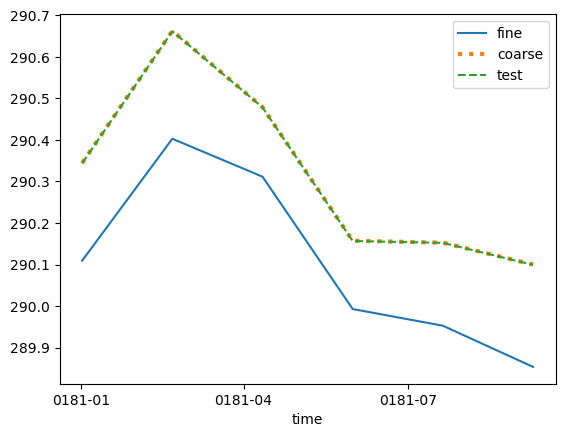

In [16]:
test_raw.plot(label='fine')
test_coarse.plot(label='coarse', ls=':', lw=3)
test_double_check.plot(label='test', ls='--')
plt.legend()

You can fix this by casting the area to float64 before, but this is still really bizarr to me...oh well. 